# import modules

In [1]:
import sys

sys.path.insert(0, "../")

from modules.Classes_ver2 import *
from modules.default_params_ver1 import *
from modules.functions_ver2 import *

# assign params

In [2]:
lens_params, RP_params, NP_params = set_to_params(
    lens_params_1, RP_params_1, NP_params_1
)

# mismatch optimized over $\tilde{\theta}$, $\tilde{\Omega}$, and $\gamma_P$

In [29]:
from multiprocessing import Pool


def compute_mismatch(r, c, tpl_params, src_params, opt_match):
    n_pts = 20
    omega_tilde_arr = np.linspace(0, 3, n_pts)
    theta_tilde_arr = np.linspace(0, 8, n_pts)
    X, Y = np.meshgrid(omega_tilde_arr, theta_tilde_arr)
    tpl_params["omega_tilde"] = X[r, c]
    tpl_params["theta_tilde"] = Y[r, c]

    optimized_mismatch_results_dict = optimize_mismatch_gammaP(
        tpl_params, src_params, use_opt_match=opt_match
    )

    return (
        optimized_mismatch_results_dict["ep_min"],
        optimized_mismatch_results_dict["ep_min_gammaP"],
    )


def mismatch_contour_parallel(tpl_params, src_params, opt_match=True):
    n_pts = 20
    omega_tilde_arr = np.linspace(0, 3, n_pts)
    theta_tilde_arr = np.linspace(0, 8, n_pts)
    X, Y = np.meshgrid(omega_tilde_arr, theta_tilde_arr)
    Z = np.zeros_like(X)
    g_min_matrix = np.zeros_like(X)

    # Create a pool of worker processes
    with Pool() as pool:
        results = []
        for r in range(n_pts):
            for c in range(n_pts):
                results.append(
                    pool.apply_async(
                        compute_mismatch, args=(r, c, tpl_params, src_params, opt_match)
                    )
                )

        for r in range(n_pts):
            for c in range(n_pts):
                idx = r * n_pts + c
                Z[r, c], g_min_matrix[r, c] = results[idx].get()

    min_idx = np.unravel_index(np.argmin(Z, axis=None), Z.shape)
    max_idx = np.unravel_index(np.argmax(Z, axis=None), Z.shape)

    results_dict = {
        "ep_0_0": Z[0, 0],
        "ep_min": Z[min_idx],
        "ep_min_omega_tilde": X[min_idx],
        "ep_min_theta_tilde": Y[min_idx],
        "ep_min_gammaP": g_min_matrix[min_idx],
        "ep_max": Z[max_idx],
        "ep_max_omega_tilde": X[max_idx],
        "ep_max_theta_tilde": Y[max_idx],
        "ep_max_gammaP": g_min_matrix[max_idx],
        "ep_max_min_ratio": Z[max_idx] / Z[min_idx],
    }

    return results_dict

# as a function of $\Delta t_d$ while fixing $I$

In [ ]:
lens_params, RP_params, NP_params = set_to_params(
    lens_params_1, RP_params_1, NP_params_1
)

I = LensingGeo(lens_params).I()
MLz_arr = np.linspace(400, 4600, 50)
Delta_td_arr = np.zeros_like(MLz_arr)

mismatch_Deltatd_dict = {}

for i, MLz in enumerate(MLz_arr):
    lens_params["MLz"] = MLz * solar_mass
    Delta_td = LensingGeo(lens_params).td()
    Delta_td_arr[i] = Delta_td
    mismatch_Deltatd_dict[Delta_td] = mismatch_contour_parallel(RP_params, lens_params)

now = datetime.now()
filename = "mismatch_Deltatd_dict_" + now.strftime("%Y-%m-%d_%H-%M-%S") + ".pkl"
filepath = os.path.join("data", filename)
with open(filepath, "wb") as f:
    pickle.dump(mismatch_Deltatd_dict, f)
    print("Results saved as", filepath)

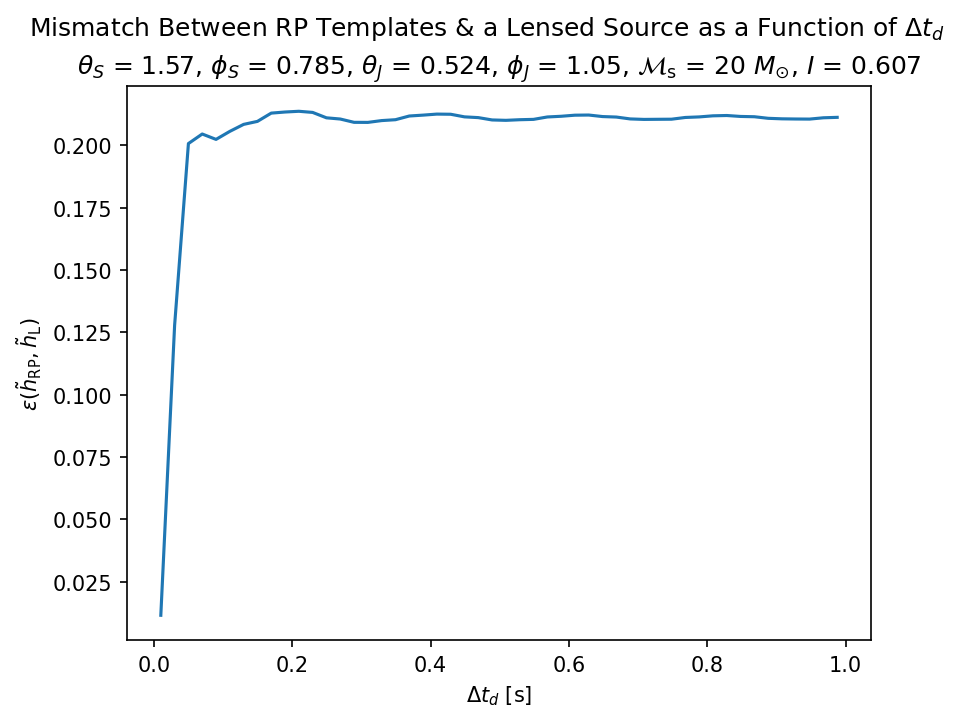

In [32]:
Deltatd_ep_min_arr = np.array(
    [mismatch_Deltatd_dict[Delta_td]["ep_min"] for Delta_td in Delta_td_arr]
)

plt.plot(
    Delta_td_arr, Deltatd_ep_min_arr, label=r"$\epsilon(\~h_{\rm RP}, \~h_{\rm L})$"
)
plt.xlabel(r"$\Delta t_d$ [s]")
plt.ylabel(r"$\epsilon(\~h_{\rm RP}, \~h_{\rm L})$")

plt.title(
    r"$\theta_S$ = {:.3g}, $\phi_S$ = {:.3g}, $\theta_J$ = {:.3g}, $\phi_J$ = {:.3g}, {} = {:.3g} {}, $I$ = {:.3g}".format(
        lens_params["theta_S"],
        lens_params["phi_S"],
        lens_params["theta_J"],
        lens_params["phi_J"],
        r"$\mathcal{M}_{\text{s}}$",
        lens_params["mcz"] / solar_mass,
        r"$M_{\odot}$",
        I,
    )
)

plt.suptitle(
    r"Mismatch Between RP Templates & a Lensed Source as a Function of $\Delta t_d$"
)

plt.show()

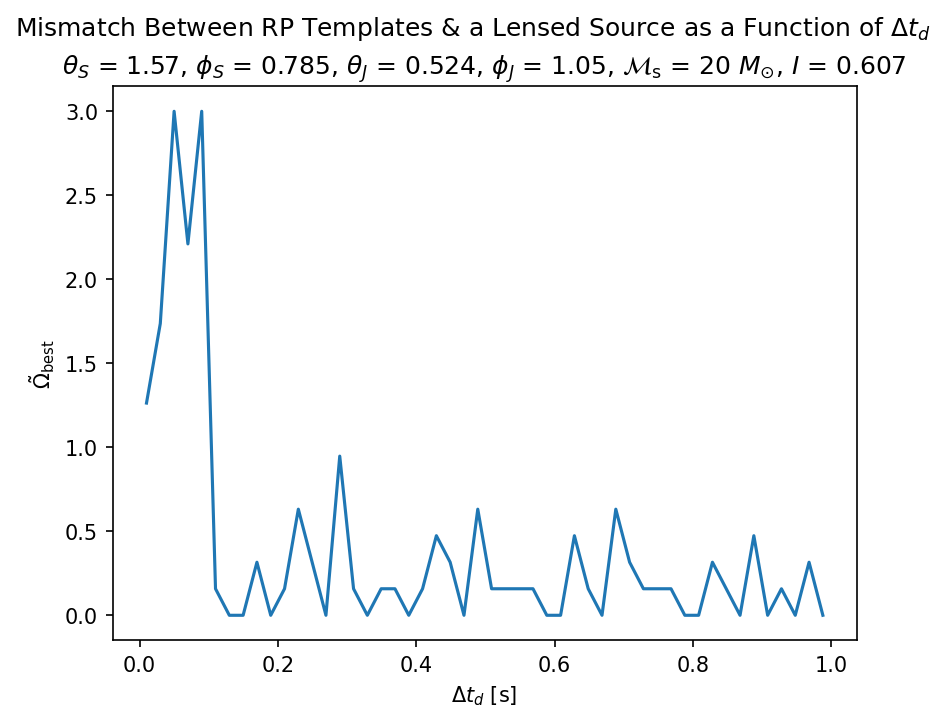

In [33]:
Deltatd_ep_min_omega_tilde_arr = np.array(
    [mismatch_Deltatd_dict[Delta_td]["ep_min_omega_tilde"] for Delta_td in Delta_td_arr]
)

plt.plot(Delta_td_arr, Deltatd_ep_min_omega_tilde_arr, label=r"$\~{\Omega}_{\rm best}$")
plt.xlabel(r"$\Delta t_d$ [s]")
plt.ylabel(r"$\~{\Omega}_{\rm best}$")

plt.title(
    r"$\theta_S$ = {:.3g}, $\phi_S$ = {:.3g}, $\theta_J$ = {:.3g}, $\phi_J$ = {:.3g}, {} = {:.3g} {}, $I$ = {:.3g}".format(
        lens_params["theta_S"],
        lens_params["phi_S"],
        lens_params["theta_J"],
        lens_params["phi_J"],
        r"$\mathcal{M}_{\text{s}}$",
        lens_params["mcz"] / solar_mass,
        r"$M_{\odot}$",
        I,
    )
)

plt.suptitle(
    r"Mismatch Between RP Templates & a Lensed Source as a Function of $\Delta t_d$"
)

plt.show()

# as a function of $I$ while fixing $\Delta t_d$

In [34]:
lens_params, RP_params, NP_params = set_to_params(
    lens_params_1, RP_params_1, NP_params_1
)

# create y_range and MLz_range based on the same time delay
y_arr = np.linspace(0.5, 3, 50)[::-1]
time_delay = 0.1
MLz_arr = get_MLz_from_td(time_delay, y_arr)
I_arr = np.zeros_like(MLz_arr)

mismatch_I_dict = {}

for i, y, MLz in zip(range(len(y_arr)), y_arr, MLz_arr):
    lens_params["y"] = y
    lens_params["MLz"] = MLz * solar_mass
    I = LensingGeo(lens_params).I()
    I_arr[i] = I
    mismatch_I_dict[I] = mismatch_contour_parallel(RP_params, lens_params)

now = datetime.now()
filename = "mismatch_I_dict_" + now.strftime("%Y-%m-%d_%H-%M-%S") + ".pkl"
filepath = os.path.join("data", filename)
with open(filepath, "wb") as f:
    pickle.dump(mismatch_I_dict, f)
    print("Results saved as", filepath)

Results saved as data/mismatch_I_dict_2024-03-18_16-03-10.pkl


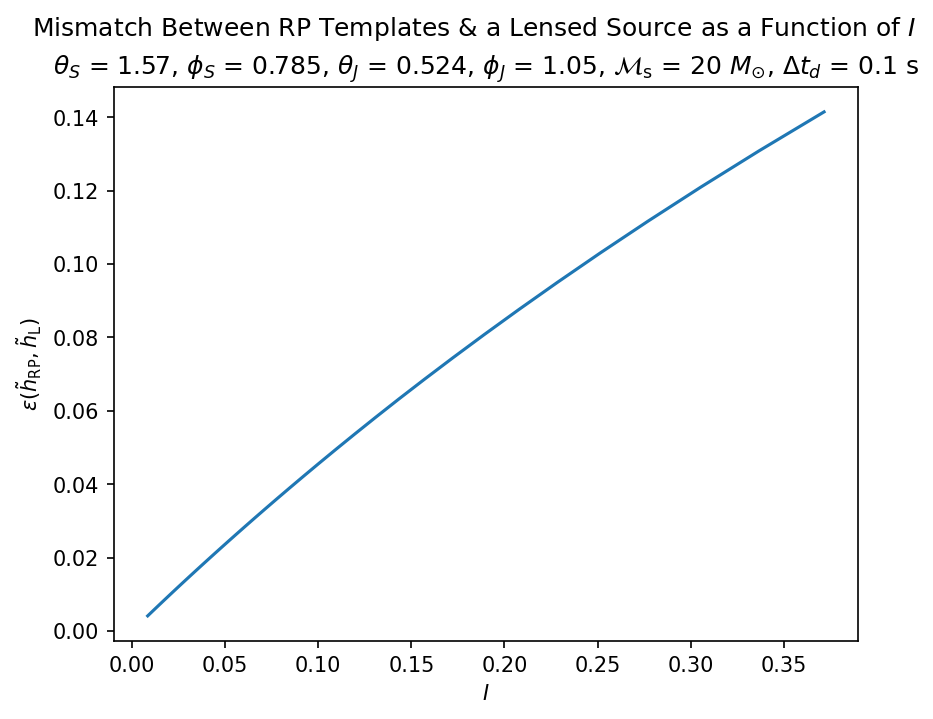

In [35]:
I_ep_min_arr = np.array([mismatch_I_dict[I]["ep_min"] for I in I_arr])

plt.plot(I_arr, I_ep_min_arr, label=r"$\epsilon(\~h_{\rm RP}, \~h_{\rm L})$")
plt.xlabel(r"$I$")
plt.ylabel(r"$\epsilon(\~h_{\rm RP}, \~h_{\rm L})$")

plt.title(
    r"$\theta_S$ = {:.3g}, $\phi_S$ = {:.3g}, $\theta_J$ = {:.3g}, $\phi_J$ = {:.3g}, {} = {:.3g} {}, $\Delta t_d$ = {:.3g} s".format(
        lens_params["theta_S"],
        lens_params["phi_S"],
        lens_params["theta_J"],
        lens_params["phi_J"],
        r"$\mathcal{M}_{\text{s}}$",
        lens_params["mcz"] / solar_mass,
        r"$M_{\odot}$",
        time_delay,
    )
)

plt.suptitle(r"Mismatch Between RP Templates & a Lensed Source as a Function of $I$")

plt.show()

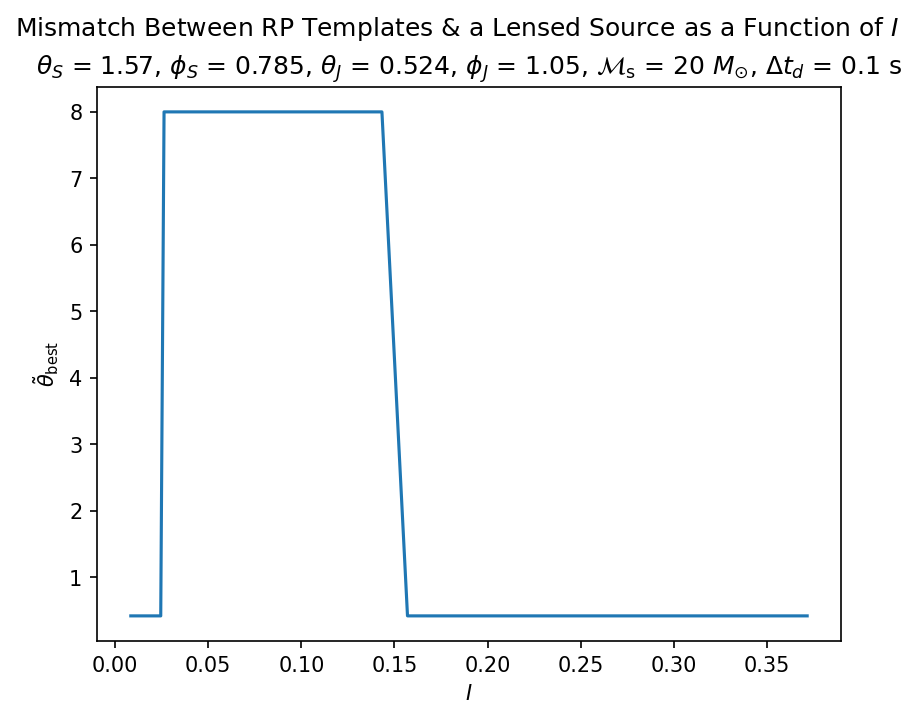

In [36]:
I_ep_min_theta_tilde_arr = np.array(
    [mismatch_I_dict[I]["ep_min_theta_tilde"] for I in I_arr]
)

plt.plot(I_arr, I_ep_min_theta_tilde_arr, label=r"$\~{\theta}_{\rm best}$")
plt.xlabel(r"$I$")
plt.ylabel(r"$\~{\theta}_{\rm best}$")

plt.title(
    r"$\theta_S$ = {:.3g}, $\phi_S$ = {:.3g}, $\theta_J$ = {:.3g}, $\phi_J$ = {:.3g}, {} = {:.3g} {}, $\Delta t_d$ = {:.3g} s".format(
        lens_params["theta_S"],
        lens_params["phi_S"],
        lens_params["theta_J"],
        lens_params["phi_J"],
        r"$\mathcal{M}_{\text{s}}$",
        lens_params["mcz"] / solar_mass,
        r"$M_{\odot}$",
        time_delay,
    )
)

plt.suptitle(r"Mismatch Between RP Templates & a Lensed Source as a Function of $I$")

plt.show()

# precession cycles

In [4]:
def number_of_prec_cycles(params, f_min=20):
    inst = Precessing(params)
    f_cut = inst.f_cut()
    phi_LJ_min = inst.phi_LJ(f_min)
    phi_LJ_cut = inst.phi_LJ(f_cut)
    n_prec_cycles = (phi_LJ_cut - phi_LJ_min) / (2 * np.pi)
    return n_prec_cycles

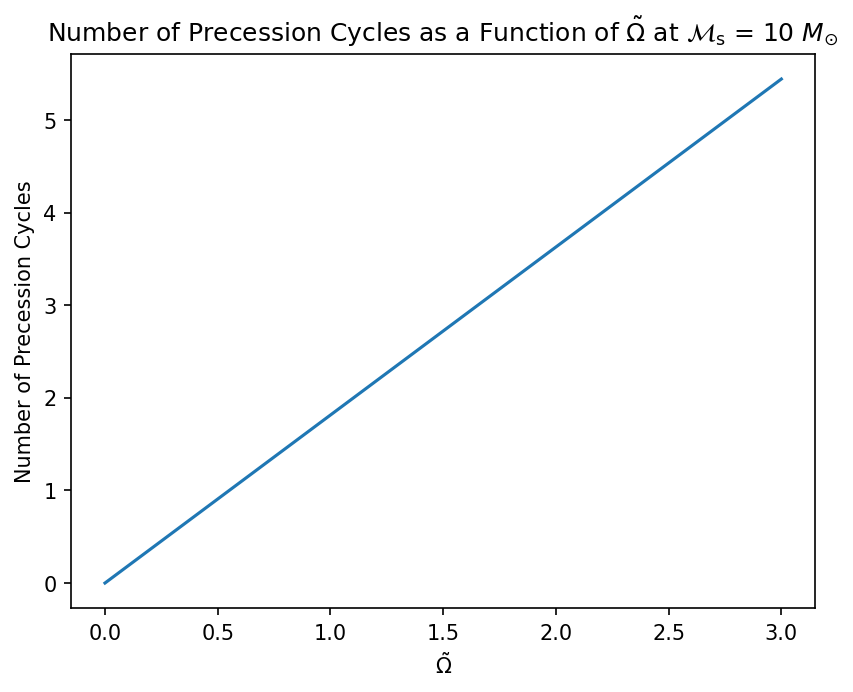

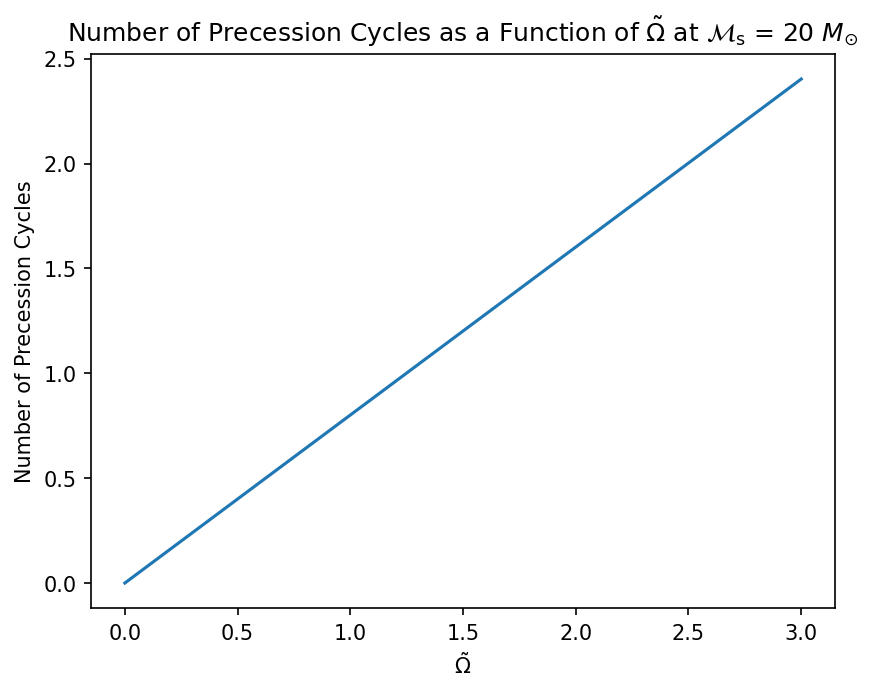

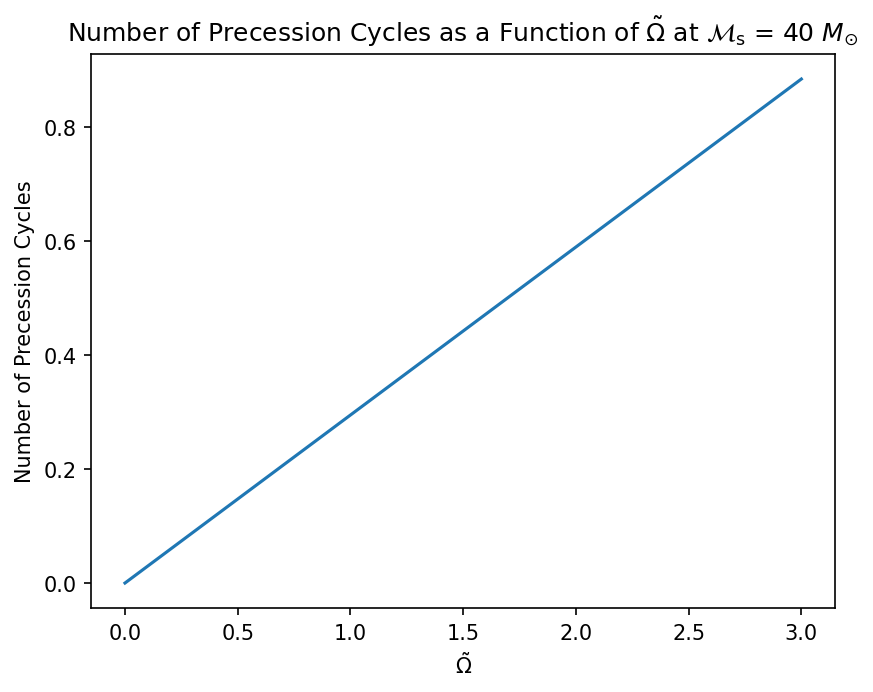

In [4]:
# for RP_params["omega_tilde"] from 0 to 3, print the number of precession cycles, using dictionary unpacking
omega_tilde_arr = np.linspace(0, 3, 50)

RP_params["mcz"] = 10 * solar_mass
n_prec_cycles_arr = np.array(
    [
        number_of_prec_cycles({**RP_params, "omega_tilde": omega_tilde})
        for omega_tilde in omega_tilde_arr
    ]
)

plt.plot(omega_tilde_arr, n_prec_cycles_arr)
plt.xlabel(r"$\~{\Omega}$")
plt.ylabel(r"Number of Precession Cycles")
plt.title(
    r"Number of Precession Cycles as a Function of {} at {} = {:.3g} {}".format(
        r"$\~{\Omega}$",
        r"$\mathcal{M}_{\text{s}}$",
        RP_params["mcz"] / solar_mass,
        r"$M_{\odot}$",
    )
)
plt.show()

RP_params["mcz"] = 20 * solar_mass
n_prec_cycles_arr = np.array(
    [
        number_of_prec_cycles({**RP_params, "omega_tilde": omega_tilde})
        for omega_tilde in omega_tilde_arr
    ]
)

plt.plot(omega_tilde_arr, n_prec_cycles_arr)
plt.xlabel(r"$\~{\Omega}$")
plt.ylabel(r"Number of Precession Cycles")
plt.title(
    r"Number of Precession Cycles as a Function of {} at {} = {:.3g} {}".format(
        r"$\~{\Omega}$",
        r"$\mathcal{M}_{\text{s}}$",
        RP_params["mcz"] / solar_mass,
        r"$M_{\odot}$",
    )
)
plt.show()

RP_params["mcz"] = 40 * solar_mass
n_prec_cycles_arr = np.array(
    [
        number_of_prec_cycles({**RP_params, "omega_tilde": omega_tilde})
        for omega_tilde in omega_tilde_arr
    ]
)

plt.plot(omega_tilde_arr, n_prec_cycles_arr)
plt.xlabel(r"$\~{\Omega}$")
plt.ylabel(r"Number of Precession Cycles")
plt.title(
    r"Number of Precession Cycles as a Function of {} at {} = {:.3g} {}".format(
        r"$\~{\Omega}$",
        r"$\mathcal{M}_{\text{s}}$",
        RP_params["mcz"] / solar_mass,
        r"$M_{\odot}$",
    )
)
plt.show()

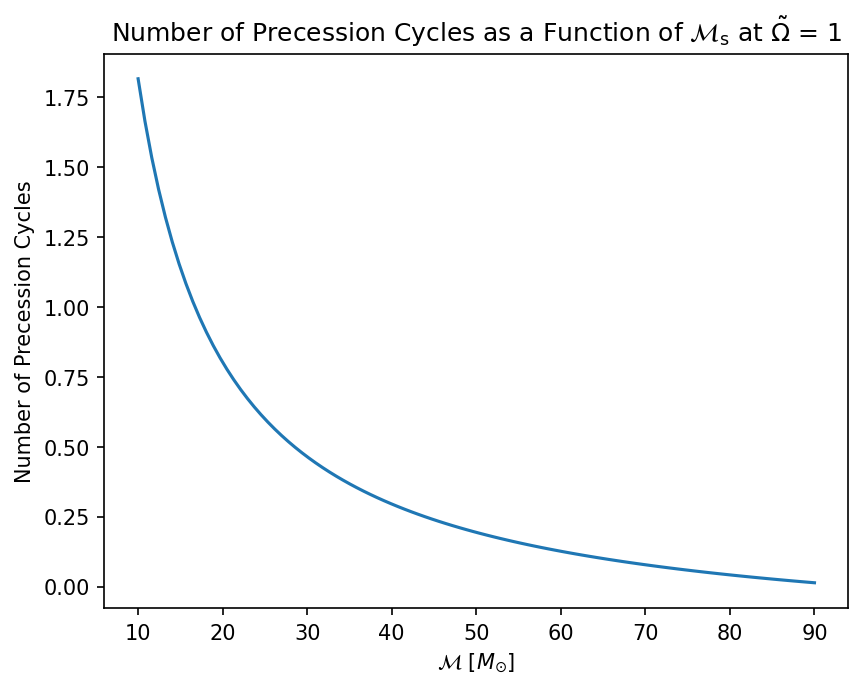

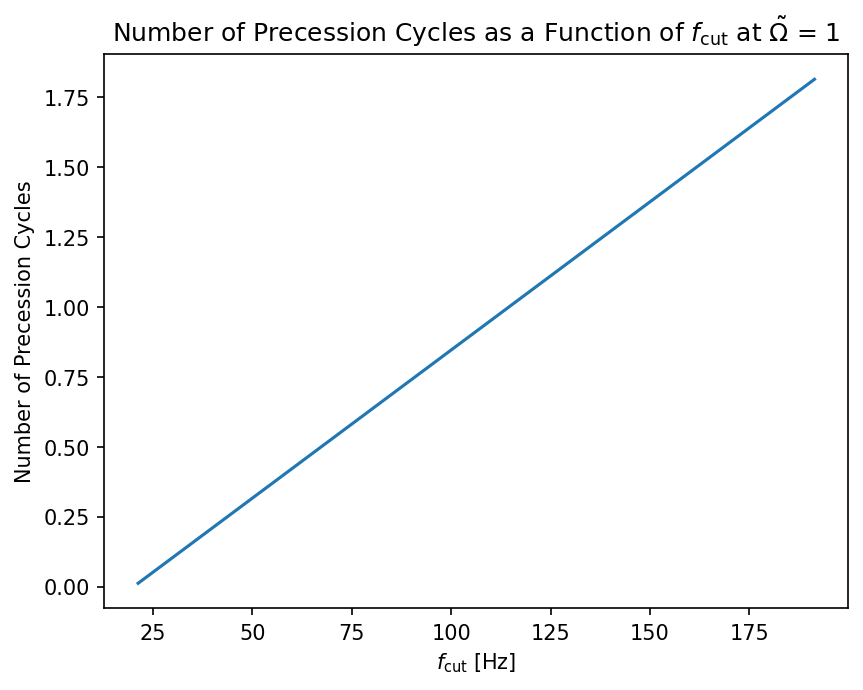

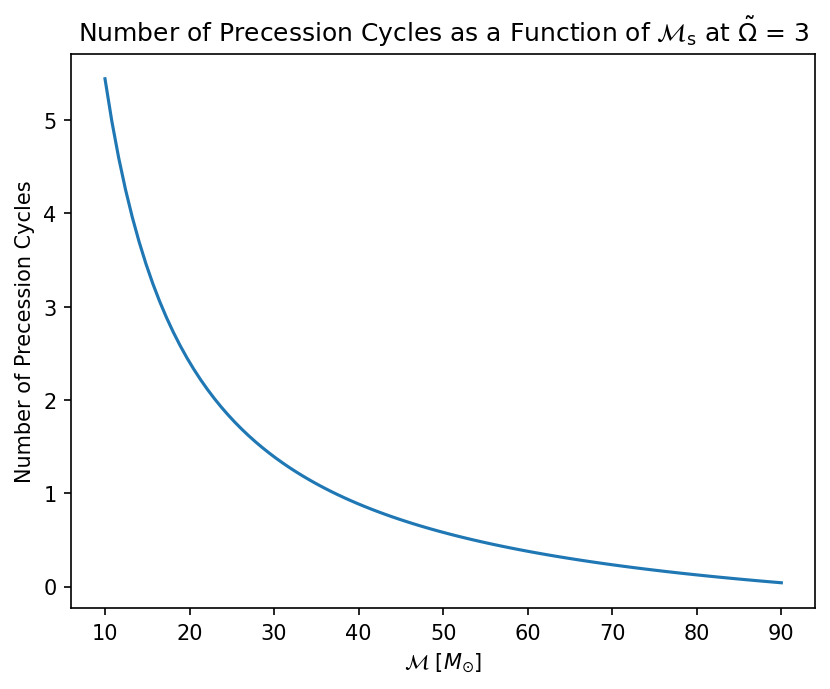

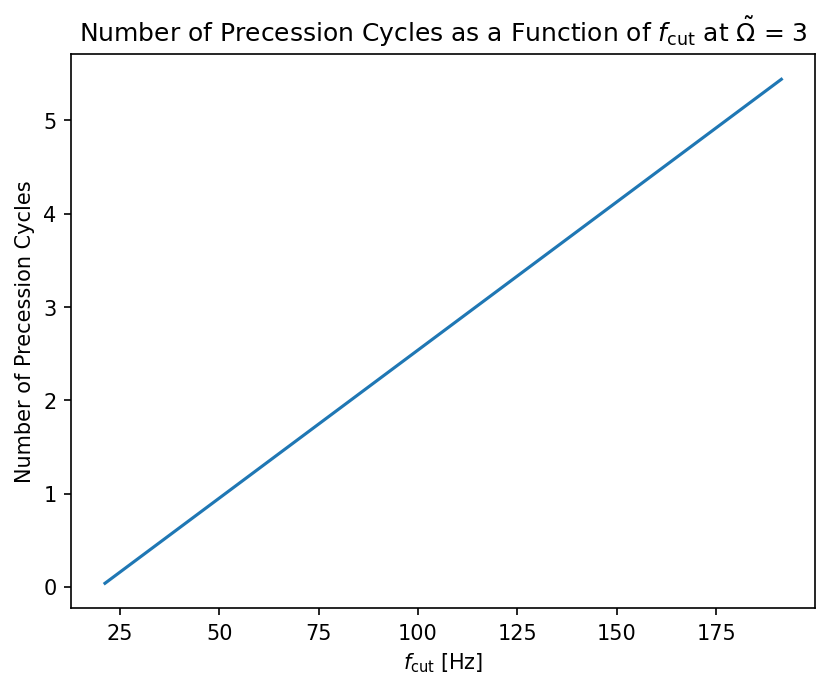

In [5]:
# plot number of precession cycles as a function of chirp mass
mcz_arr = np.linspace(10, 90, 100)
f_cut_arr = get_fcut_from_mcz(mcz_arr, RP_params["eta"])
n_prec_cycles_arr = np.zeros_like(mcz_arr)

RP_params["omega_tilde"] = 1
for i, mcz in enumerate(mcz_arr):
    RP_params["mcz"] = mcz * solar_mass
    n_prec_cycles_arr[i] = number_of_prec_cycles(RP_params)

plt.plot(mcz_arr, n_prec_cycles_arr)
plt.xlabel(r"$\mathcal{M}$ [$M_{\odot}$]")
plt.ylabel(r"Number of Precession Cycles")
plt.title(
    r"Number of Precession Cycles as a Function of {} at {} = {:.3g}".format(
        r"$\mathcal{M}_{\text{s}}$", r"$\~{\Omega}$", RP_params["omega_tilde"]
    )
)
plt.show()

# plot number of precession cycles as a function of f_cut
plt.plot(f_cut_arr, n_prec_cycles_arr)
plt.xlabel(r"$f_{\rm cut}$ [Hz]")
plt.ylabel(r"Number of Precession Cycles")
plt.title(
    r"Number of Precession Cycles as a Function of {} at {} = {:.3g}".format(
        r"$f_{\rm cut}$", r"$\~{\Omega}$", RP_params["omega_tilde"]
    )
)
plt.show()

RP_params["omega_tilde"] = 3
for i, mcz in enumerate(mcz_arr):
    RP_params["mcz"] = mcz * solar_mass
    n_prec_cycles_arr[i] = number_of_prec_cycles(RP_params)

plt.plot(mcz_arr, n_prec_cycles_arr)
plt.xlabel(r"$\mathcal{M}$ [$M_{\odot}$]")
plt.ylabel(r"Number of Precession Cycles")
plt.title(
    r"Number of Precession Cycles as a Function of {} at {} = {:.3g}".format(
        r"$\mathcal{M}_{\text{s}}$", r"$\~{\Omega}$", RP_params["omega_tilde"]
    )
)
plt.show()

# plot number of precession cycles as a function of f_cut
plt.plot(f_cut_arr, n_prec_cycles_arr)
plt.xlabel(r"$f_{\rm cut}$ [Hz]")
plt.ylabel(r"Number of Precession Cycles")
plt.title(
    r"Number of Precession Cycles as a Function of {} at {} = {:.3g}".format(
        r"$f_{\rm cut}$", r"$\~{\Omega}$", RP_params["omega_tilde"]
    )
)
plt.show()

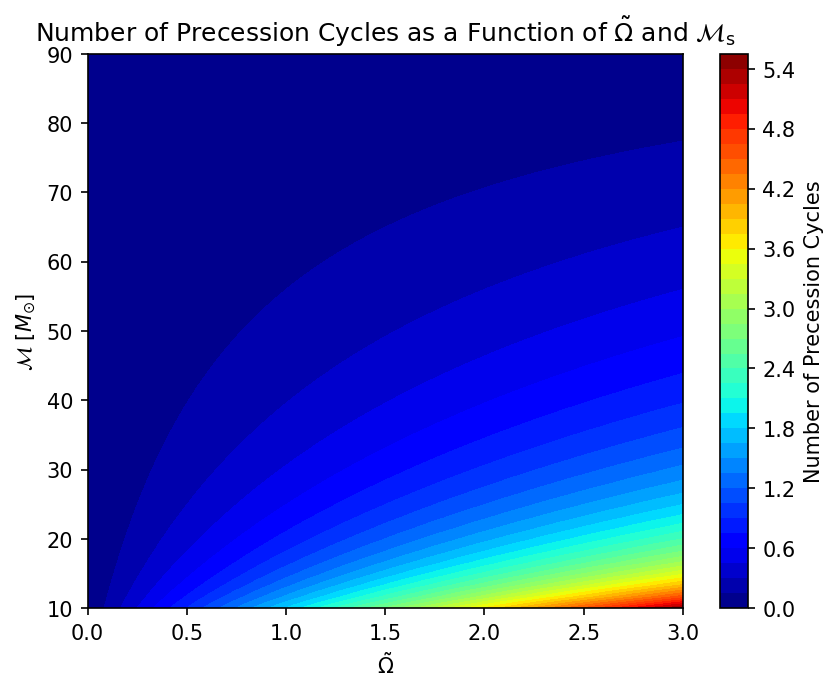

In [6]:
# create contour plot of number of precession cycles as a function of omega_tilde and mcz
n_pts = 50
omega_tilde_arr = np.linspace(0, 3, n_pts)
mcz_arr = np.linspace(10, 90, n_pts)
X, Y = np.meshgrid(omega_tilde_arr, mcz_arr)
Z = np.zeros_like(X)

for r in range(n_pts):
    for c in range(n_pts):
        RP_params["omega_tilde"] = X[r, c]
        RP_params["mcz"] = Y[r, c] * solar_mass
        Z[r, c] = number_of_prec_cycles(RP_params)

plt.contourf(X, Y, Z, levels=50, cmap="jet")
plt.xlabel(r"$\~{\Omega}$")
plt.ylabel(r"$\mathcal{M}$ [$M_{\odot}$]")
plt.title(
    r"Number of Precession Cycles as a Function of {} and {}".format(
        r"$\~{\Omega}$", r"$\mathcal{M}_{\text{s}}$"
    )
)
plt.colorbar(label="Number of Precession Cycles")
plt.show()

# $\Delta t_d$ & $M_{\rm Lz}$ & $\~\Omega$ limits

In [5]:
lens_params, RP_params, NP_params = set_to_params(
    lens_params_1, RP_params_1, NP_params_1
)

f_min = 20
MLz_min = (1 / (8 * np.pi * f_min)) / solar_mass
lens_params["MLz"] = MLz_min * solar_mass
Delta_td_min = LensingGeo(lens_params).td()

RP_params["mcz"] = 20 * solar_mass
RP_params["omega_tilde"] = 3
n_prec_cycles = number_of_prec_cycles(RP_params, f_min=f_min)
print("Number of precession cycles =", n_prec_cycles)
f_cut = get_fcut_from_mcz(RP_params["mcz"] / solar_mass, RP_params["eta"])
Delta_td_max = math.ceil(n_prec_cycles) / (f_cut - f_min)
MLz_max = get_MLz_from_td(Delta_td_max, lens_params["y"])

print("Delta_td_min =", Delta_td_min, "s")
print("Delta_td_max =", Delta_td_max, "s")
print("MLz_min =", MLz_min, "solar masses")
print("MLz_max =", MLz_max, "solar masses")

Number of precession cycles = 2.403243520405414
Delta_td_min = 0.0039892110766206225 s
Delta_td_max = 0.039638230866185946 s
MLz_min = 403.8448150570481 solar masses
MLz_max = 4012.7468077984045 solar masses


# create equidistant $I$ values from $y$ array

## equidistant $y$ values &rarr; $I$ values

In [69]:
td = 0.02
y_arr = np.linspace(0.5, 3, 50)[::-1]
MLz_arr = get_MLz_from_td(td, y_arr)
I_arr = get_I_from_y(y_arr)

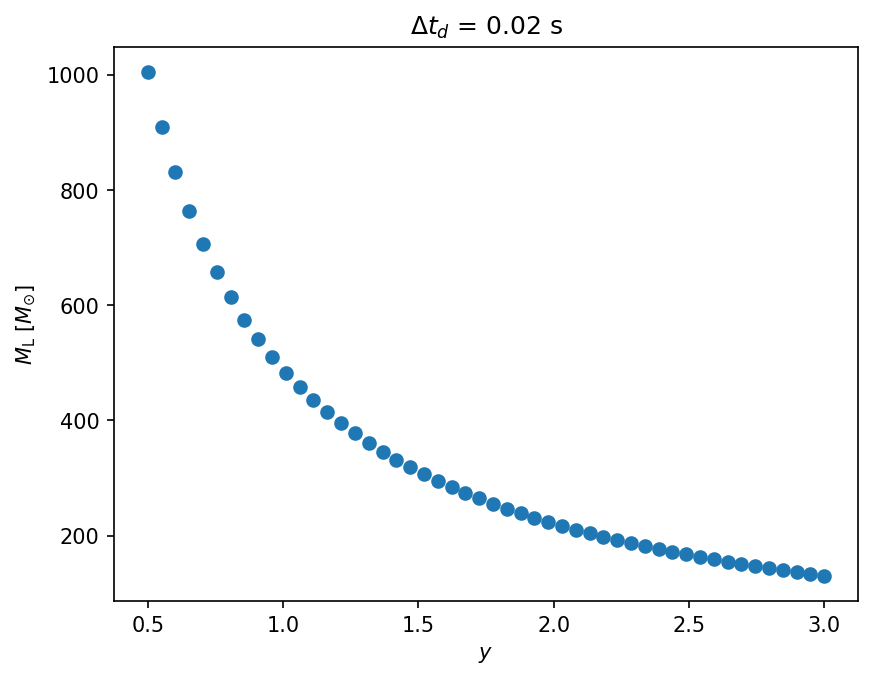

In [70]:
plt.scatter(y_arr, MLz_arr)
plt.xlabel(r"$y$")
plt.ylabel(r"$M_{\rm L}$ [$M_{\odot}$]")
plt.title(r"$\Delta t_d$ = {:.3g} s".format(td))
plt.show()

[0.00840395 0.00889634 0.00942396 0.00998978 0.01059703 0.01124926
 0.01195034 0.01270454 0.01351656 0.01439154 0.01533516 0.01635366
 0.01745392 0.01864355 0.01993091 0.02132528 0.02283689 0.02447707
 0.02625837 0.0281947  0.03030147 0.0325958  0.03509669 0.03782527
 0.04080501 0.04406204 0.04762546 0.05152766 0.05580475 0.06049698
 0.06564925 0.07131165 0.07754008 0.08439696 0.09195194 0.10028283
 0.10947649 0.11962991 0.13085136 0.1432617  0.15699576 0.17220394
 0.1890539  0.20773244 0.22844752 0.25143048 0.27693848 0.30525703
 0.33670279 0.37162654]


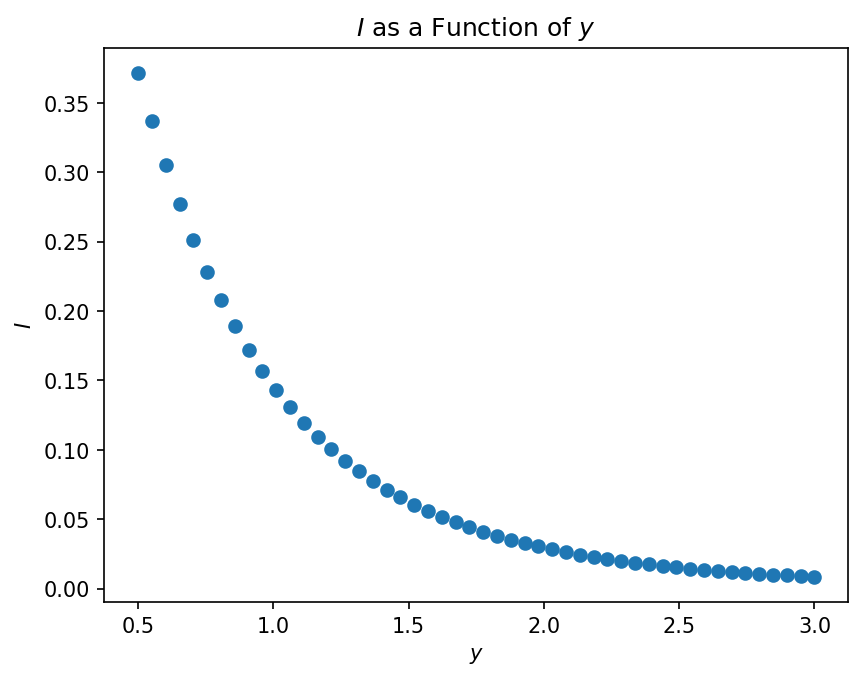

In [71]:
plt.scatter(y_arr, I_arr)
plt.xlabel(r"$y$")
plt.ylabel(r"$I$")
plt.title(r"$I$ as a Function of $y$")
print(I_arr)

In [72]:
from scipy.optimize import fsolve

# solve for y for every I in I_arr
y_roots_arr = np.array([fsolve(lambda y: get_I_from_y(y) - I, 1)[0] for I in I_arr])
print("y roots =", y_roots_arr)
print("y_arr =", y_arr)
print(np.around(y_roots_arr - y_arr, 3))

y roots = [3.         2.94897959 2.89795918 2.84693878 2.79591837 2.74489796
 2.69387755 2.64285714 2.59183673 2.54081633 2.48979592 2.43877551
 2.3877551  2.33673469 2.28571429 2.23469388 2.18367347 2.13265306
 2.08163265 2.03061224 1.97959184 1.92857143 1.87755102 1.82653061
 1.7755102  1.7244898  1.67346939 1.62244898 1.57142857 1.52040816
 1.46938776 1.41836735 1.36734694 1.31632653 1.26530612 1.21428571
 1.16326531 1.1122449  1.06122449 1.01020408 0.95918367 0.90816327
 0.85714286 0.80612245 0.75510204 0.70408163 0.65306122 0.60204082
 0.55102041 0.5       ]
y_arr = [3.         2.94897959 2.89795918 2.84693878 2.79591837 2.74489796
 2.69387755 2.64285714 2.59183673 2.54081633 2.48979592 2.43877551
 2.3877551  2.33673469 2.28571429 2.23469388 2.18367347 2.13265306
 2.08163265 2.03061224 1.97959184 1.92857143 1.87755102 1.82653061
 1.7755102  1.7244898  1.67346939 1.62244898 1.57142857 1.52040816
 1.46938776 1.41836735 1.36734694 1.31632653 1.26530612 1.21428571
 1.16326531 1.112244

In [73]:
from scipy.optimize import root_scalar

# solve for y for every I in I_arr
y_roots_arr = np.array(
    [
        root_scalar(lambda y: get_I_from_y(y) - I, bracket=[1e-10, 1e10]).root
        for I in I_arr
    ]
)
print("y roots =", y_roots_arr)
print("y_arr =", y_arr)
print(np.around(y_roots_arr - y_arr, 3))

y roots = [3.         2.94897959 2.89795918 2.84693878 2.79591837 2.74489796
 2.69387755 2.64285714 2.59183673 2.54081633 2.48979592 2.43877551
 2.3877551  2.33673469 2.28571429 2.23469388 2.18367347 2.13265306
 2.08163265 2.03061224 1.97959184 1.92857143 1.87755102 1.82653061
 1.7755102  1.7244898  1.67346939 1.62244898 1.57142857 1.52040816
 1.46938776 1.41836735 1.36734694 1.31632653 1.26530612 1.21428571
 1.16326531 1.1122449  1.06122449 1.01020408 0.95918367 0.90816327
 0.85714286 0.80612245 0.75510204 0.70408163 0.65306122 0.60204082
 0.55102041 0.5       ]
y_arr = [3.         2.94897959 2.89795918 2.84693878 2.79591837 2.74489796
 2.69387755 2.64285714 2.59183673 2.54081633 2.48979592 2.43877551
 2.3877551  2.33673469 2.28571429 2.23469388 2.18367347 2.13265306
 2.08163265 2.03061224 1.97959184 1.92857143 1.87755102 1.82653061
 1.7755102  1.7244898  1.67346939 1.62244898 1.57142857 1.52040816
 1.46938776 1.41836735 1.36734694 1.31632653 1.26530612 1.21428571
 1.16326531 1.112244

## equidistant $I$ values &rarr; $y$ values

In [77]:
td = 0.02
I_arr = np.linspace(0.1, 0.9, 50)
y_arr = np.array([fsolve(lambda y: get_I_from_y(y) - I, 1)[0] for I in I_arr])
MLz_arr = get_MLz_from_td(td, y_arr)
print("y_arr =", y_arr)
print("MLz_arr =", MLz_arr)

y_arr = [1.21593808 1.12829256 1.05349019 0.98832939 0.9306599  0.87897051
 0.83216019 0.78940291 0.75006363 0.71364407 0.67974629 0.64804764
 0.61828299 0.59023195 0.56370937 0.53855829 0.51464449 0.49185236
 0.47008163 0.44924475 0.42926489 0.41007425 0.39161269 0.37382665
 0.3566682  0.34009431 0.3240662  0.3085488  0.29351027 0.27892168
 0.26475658 0.25099081 0.23760219 0.22457034 0.21187646 0.1995032
 0.18743452 0.17565553 0.16415241 0.1529123  0.14192321 0.13117396
 0.12065409 0.11035381 0.10026393 0.09037585 0.08068145 0.07117312
 0.06184368 0.05268635]
MLz_arr = [ 394.26866572  428.05401287  461.20152206  494.05024046  526.85801256
  559.83197738  593.14669153  626.95558728  661.39862613  696.60768326
  732.7105364   769.83398189  808.10640659  847.66003235  888.63298436
  931.17129532  975.43093504 1021.57994299 1069.80073693 1120.29267153
 1173.27492751 1228.98982246 1287.70665058 1349.72618138 1415.38597669
 1485.06672582 1559.19985092 1638.27670507 1722.85977929 1813.596461

In [3]:
td = 0.02
I_arr = np.linspace(0.1, 0.9, 50)
y_arr = get_y_from_I(I_arr)
MLz_arr = get_MLz_from_td(td, y_arr)

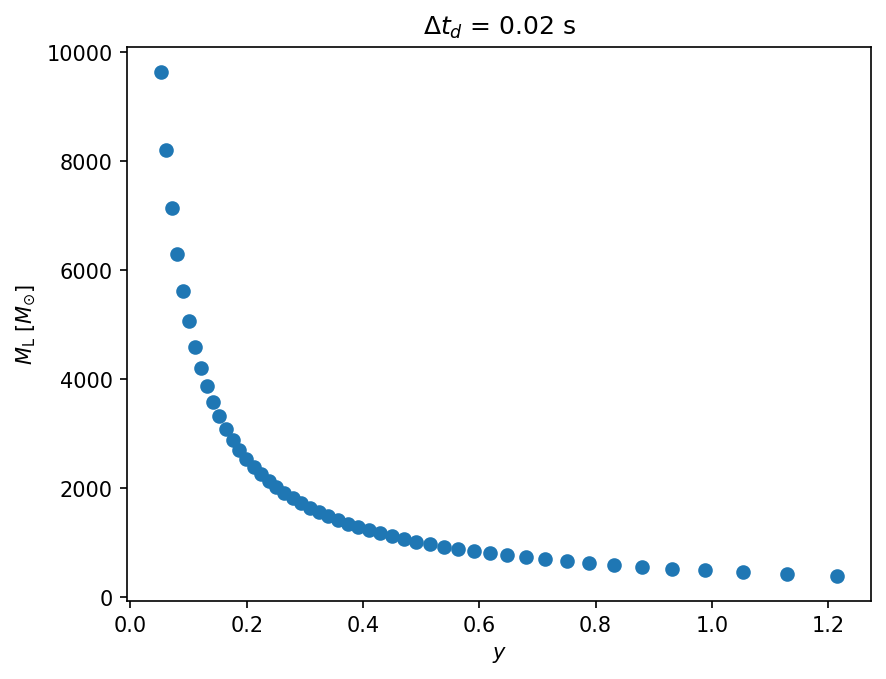

In [4]:
plt.scatter(y_arr, MLz_arr)
plt.xlabel(r"$y$")
plt.ylabel(r"$M_{\rm L}$ [$M_{\odot}$]")
plt.title(r"$\Delta t_d$ = {:.3g} s".format(td))
plt.show()

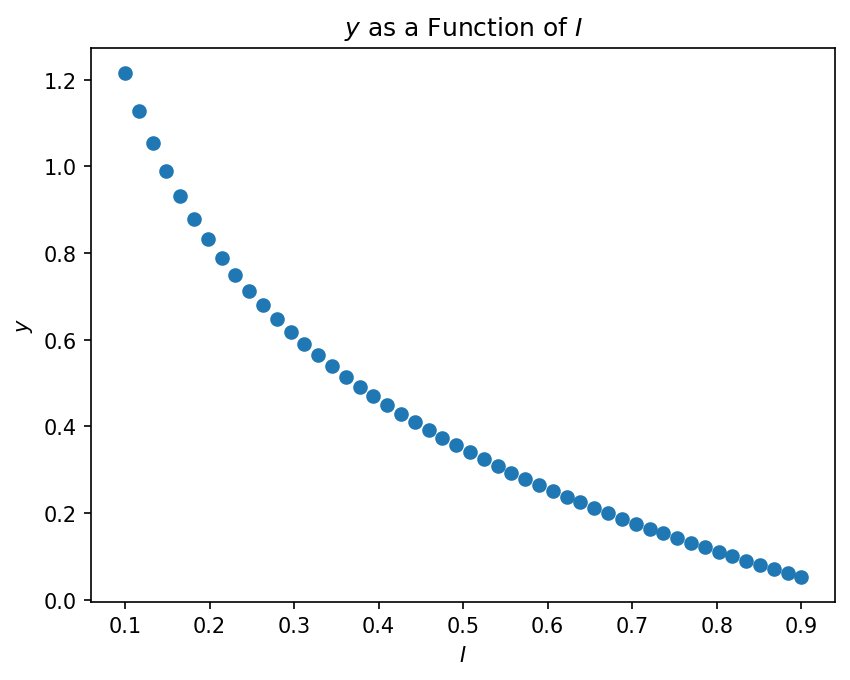

In [7]:
plt.scatter(I_arr, y_arr)
plt.xlabel(r"$I$")
plt.ylabel(r"$y$")
plt.title(r"$y$ as a Function of $I$")
plt.show()

# $I$ & $y$ & $\~\theta$ limits